In [1]:
!pip3 install numpy==1.15.4
!pip3 install pandas==0.25.2
!pip3 install keras_radam


     |████████████████████████████████| 13.9MB 4.9MB/s 
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


     |████████████████████████████████| 10.4MB 4.8MB/s 
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


  Created wheel for keras-radam: filename=keras_radam-0.15.0-cp36-none-any.whl size=14686 sha256=2e7d2ec0066fac2782dbf01123e276bdfc76a07ce3cfba69a925f5224def3ad4
  Stored in directory: /root/.cache/pip/wheels/79/a0/c0/670b0a118e8f078539fafec7bd02eba0af921f745660c7f83f
Successfully built keras-radam


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
import random
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)
from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'
path_new = '../input/lag-transform/'
path_new = '../input/transformer/'
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import log
import lightgbm as lgb
import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import holidays
import os
from sklearn.preprocessing import MinMaxScaler
import os
# Any results you write to the current directory are saved as output.

from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras_radam import RAdam

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def ls():
     print([v for v in globals().keys() if not v.startswith('_')])

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()
    
def chunk_predictor(X,model,n=100,verbose=True):
    predict_fold = KFold(n)
    result = np.zeros(X.shape[0])
    if verbose:
        for trn_idx, val_idx in tqdm_notebook(predict_fold.split(X)):
               result[val_idx] = model.predict(X.iloc[val_idx,:])
    else:
        for trn_idx, val_idx in predict_fold.split(X):
            result[val_idx] = model.predict(X.iloc[val_idx,:])
    return(result)

Using TensorFlow backend.


In [0]:
def model(dense_dim_1=128, dense_dim_2=64, dense_dim_3=64, dense_dim_4=32, 
          dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001):

    #Inputs
    emb_col = category_column
   
    embed_list = {x : Input(shape=[1], name = x) for x in emb_col}
    numeric_list = [Input(shape=[1], name = x) for x in numeric_col]
    max_index = train[category_column].max()
    #Embeddings layers
    emb_building_id = Embedding(max_index['building_id']+1, 15)(embed_list['building_id'])
    emb_meter = Embedding(max_index['meter']+1, 2)(embed_list['meter'])
    emb_day = Embedding(max_index['day']+1, 4)(embed_list['day'])
    emb_hour = Embedding(max_index['hour']+1, 4)(embed_list['hour'])
    emb_weekday = Embedding(max_index['weekend']+1, 3)(embed_list['weekend'])
    emb_floor = Embedding(max_index['floor_count']+1, 2)(embed_list['floor_count'])
    emb_site_id = Embedding(max_index['site_id']+1, 4)(embed_list['site_id'])
    emb_primary_use = Embedding(max_index['primary_use']+1, 4)(embed_list['primary_use'])
    emb_diff_meter = Embedding(max_index['diff_meter']+1, 1)(embed_list['diff_meter']) 
    emb_building_meter = Embedding(max_index['building_meter']+1, 1)(embed_list['building_meter']) 


    concat_emb = concatenate([
           Flatten() (emb_building_id)
         , Flatten() (emb_meter)
         , Flatten() (emb_day)
         , Flatten() (emb_hour)
         , Flatten() (emb_weekday)
         , Flatten() (emb_floor)
         , Flatten() (emb_site_id)
         , Flatten() (emb_primary_use)
         , Flatten() (emb_diff_meter)
         , Flatten() (emb_building_meter)

    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([categ] + numeric_list)
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
    
    #output
    output = Dense(1) (main_l)

    model = Model([embed_list[x] for x in emb_col] + numeric_list, output)

    model.compile(optimizer = RAdam(learning_rate=lr),#Adam(lr=lr),
                  loss= mse_loss,
                  metrics=[root_mean_squared_error])
    return model

def load_trained_model(weights_path,param):
    modelf = model(**param)
    modelf.load_weights(weights_path)
    return(modelf)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

def get_keras_data(df):
    column = category_column + [x for x in df.columns if x not in category_column]
    X = {col: np.array(df[col]) for col in column}
    return X

def train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, weight_valid, fold, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=0)
    model_checkpoint = ModelCheckpoint("model_" + str(fold) + ".hdf5",
                                       save_best_only=True, verbose=0, monitor='val_root_mean_squared_error', mode='min')

    hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid,weight_valid), verbose=2,
                            callbacks=[early_stopping, model_checkpoint])
    score = np.min(hist.history['val_root_mean_squared_error'])
    keras_model = load_model("model_" + str(fold) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error,
                                                                            'RAdam': RAdam})
    
    return(keras_model,score)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_load = '/content/drive/My Drive/Ashae/'
train = pd.read_hdf(f'{path_load}dataset.h5',key='train')
column = pd.read_hdf(f'{path_load}dataset.h5',key='column')['column'].tolist()
category_column = pd.read_hdf(f'{path_load}dataset.h5',key='category_column')['cat_column'].tolist()
target = pd.read_hdf(f'{path_load}dataset.h5',key='target_site0_mod')
gc.collect()

33

In [5]:
numeric_col = [x for x in train.columns if x not in category_column]

tr_min = train[numeric_col].min(axis=0)
gc.collect()
tr_max = train[numeric_col].max(axis=0)
tr_den = (tr_max-tr_min)
gc.collect()

0

In [6]:
%%time 
#preprocess - NN

train[numeric_col] = train[numeric_col]-tr_min
train[numeric_col] = train[numeric_col]/tr_den
train.fillna(-1,inplace=True)
gc.collect()

CPU times: user 25.4 s, sys: 3.49 s, total: 28.9 s
Wall time: 26.2 s


In [7]:
SEED = 42
seed_everything(SEED)
gc.collect()

0

In [0]:
max_index = train[category_column].max()
keras_param ={
    'dense_dim_1':128,
    'dense_dim_2':64,
    'dense_dim_3':64,
    'dense_dim_4':32,
    'dropout1':0.2,
    'dropout2':0.2,
    'dropout3':0.2,
    'dropout4':0.1,
    'lr':0.001
}


In [9]:
%%time
strat =train['building_id'].astype(str).copy() + train['meter'].astype(str).copy()
le = LabelEncoder()
strat = le.fit_transform(strat).astype(np.int16)
free_space(['le'])
gc.collect()

CPU times: user 29.6 s, sys: 1.87 s, total: 31.5 s
Wall time: 31.4 s


In [0]:
leak = [0,1,2,15]
# weight_train = train['building_id'].map(1/train['building_id'].value_counts())
weight_test = (~np.isin(train['site_id'],leak)).astype(int)

In [11]:
%%time
gc.collect()
num_boost=0

score = 0
n_fold = 2
folds = StratifiedKFold(n_splits=n_fold, shuffle=False,random_state=0)
pred = np.zeros(train.shape[0])

batch_size = 2048
epochs = 100


gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm_notebook(enumerate(folds.split(train,strat))):
        gc.collect()
        train_x, train_y = train.iloc[trn_idx,:], target.iloc[trn_idx]
        valid_x, valid_y = train.iloc[val_idx,:], target.iloc[val_idx]
        X_t = get_keras_data(train_x)
        X_v = get_keras_data(valid_x)

        keras_model = model(**keras_param)
        
        mod, score_temp = train_model(keras_model, X_t, train_y, batch_size, epochs, X_v, valid_y,weight_test[val_idx], fold_, patience=3)

        pred[val_idx] = mod.predict(X_v, batch_size=2048)[:,0]

        score += score_temp/n_fold
        print('Fold: {}; RMSE: {:.3f}\n'.format(fold_,score_temp))
        free_space(['keras_model','mod','X_t','X_v'])
        
print('RLMSE : {}\n'.format(score))
valid_build = train['building_id'].copy()
valid_meter = train['meter'].copy()
gc.collect()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 9614444 samples, validate on 9615396 samples
Epoch 1/100





 - 128s - loss: 1.5358 - root_mean_squared_error: 1.1295 - val_loss: 0.8327 - val_root_mean_squared_error: 0.8628
Epoch 2/100
 - 126s - loss: 0.6883 - root_mean_squared_error: 0.8286 - val_loss: 0.8439 - val_root_mean_squared_error: 0.8613
Epoch 3/100
 - 125s - loss: 0.6042 - root_mean_squared_error: 0.7763 - val_loss: 0.8536 - val_root_mean_squared_error: 0.8575
Epoch 4/100
 - 126s - loss: 0.5668 - root_mean_squared_error: 0.7520 - val_loss: 0.8620 - val_root_mean_squared_error: 0.8603
Fold: 0; RMSE: 0.858

Train on 9615396 samples, validate on 9614444 samples
Epoch 1/100
 - 130s - loss: 1.9173 - root_mean_squared_error: 1.2119 - val_loss: 0.8867 - val_root_mean_squared_error: 0.8758
Epoch 2/100
 - 127s - loss: 0.6839 - root_mean_squared_error: 0.8259 - val_loss: 0.8919 - val_root_mean_squared_

In [12]:
result = pd.DataFrame({'Building_ID':valid_build,'meter':valid_meter,'target_real':target,'target_pred':pred}).dropna()
result.reset_index(drop=True,inplace=True)
gc.collect()

free_space(['valid_build','valid_meter','pred'])

gc.collect()

0

In [13]:
%%time
test = pd.read_hdf(f'{path_load}dataset.h5',key='test')
for i in range(len(numeric_col)):
  test[numeric_col[i]] = test[numeric_col[i]]-tr_min[i]
  test[numeric_col[i]] = test[numeric_col[i]]/tr_den[i]

test.fillna(-1,inplace=True)
gc.collect()

gc.collect()

models = [load_trained_model("model_" + str(fold) + ".hdf5",keras_param) for fold in range(n_fold)]
free_space(['train'])

print('Begin scoring test set...\n')


from tqdm import tqdm
i=0
res = np.zeros((test.shape[0]),dtype=np.float32)
step_size = 50000
for j in tqdm_notebook(range(int(np.ceil(test.shape[0]/step_size)))):
    for_prediction = get_keras_data(test.iloc[i:i+step_size])
    res[i:min(i+step_size,test.shape[0])] = (sum([np.expm1(model.predict(for_prediction, batch_size=2048)[:,0]) for model in models]))/n_fold
    i+=step_size

res[(test.site_id==0) & (test.meter==0)] = res[(test.site_id==0) & (test.meter==0)] * 3.4118

Begin scoring test set...




CPU times: user 8min 49s, sys: 1min 4s, total: 9min 53s
Wall time: 6min 25s


In [0]:
gc.collect()
sample_submission = pd.read_csv(f'{path_load}sample_submission.csv')
sample_submission['meter_reading'] = res
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('{}submission/submission_nn_score{}.csv'.format(path_load,score),index=False)

In [15]:
sample_submission.iloc[:50,:]

,row_id,meter_reading
0,0,168.871307
1,1,97.150955
2,2,13.646312
3,3,245.739395
4,4,1208.386108
...,...,...
45,45,104.525688
46,46,174.521790
47,47,376.230896
48,48,238.475998


In [0]:
def fun_rmse_group(x):
    return(math.sqrt(mean_squared_error(x['target_real'],x['target_pred'])))

rmse_group_data = result.groupby(['Building_ID','meter']).apply(fun_rmse_group)
score_by_group = rmse_group_data.mean()

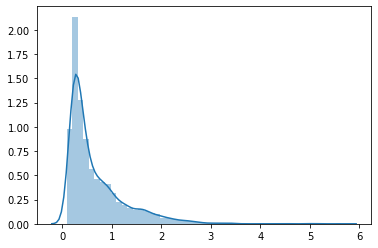

In [17]:
sns.distplot(rmse_group_data,label='RMSE by Building ID and meter')

In [18]:
print('Mean RMSLE by building and meter : {}'.format(score_by_group))

Mean RMSLE by building and meter : 0.6697811846403586


In [0]:
error_id = rmse_group_data.sort_values(ascending =False)
error_id = pd.DataFrame({'building_id':rmse_group_data.sort_values(ascending =False).index.get_level_values('Building_ID'),
                         'meter':rmse_group_data.sort_values(ascending =False).index.get_level_values('meter'),'error':error_id.values})
error_id.to_csv('error_by_id.csv',index=False)

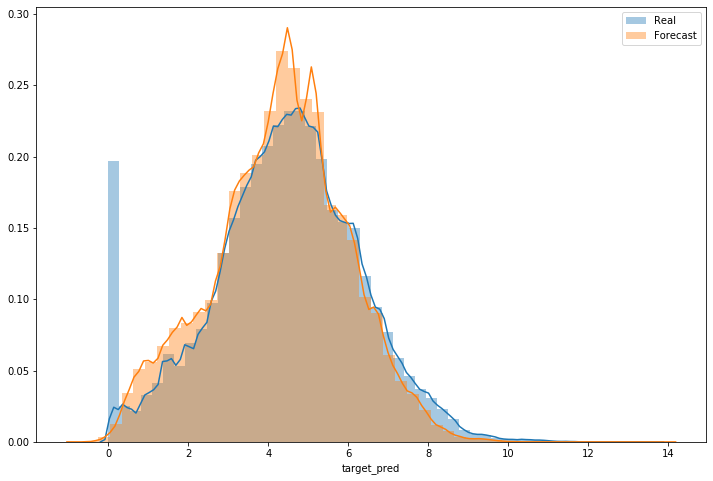

In [20]:
fig = plt.figure(figsize=(12,8))
sns.distplot(result.target_real,label='Real')
sns.distplot(result.target_pred,label='Forecast')
plt.legend()


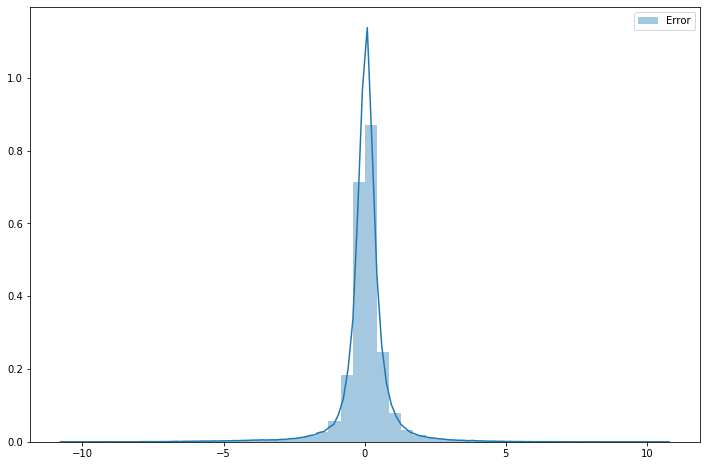

In [21]:
import seaborn as sns 
fig = plt.figure(figsize=(12,8))
sns.distplot((result.target_real-result.target_pred),label ='Error')
plt.legend()


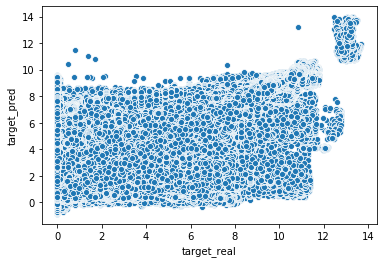

In [22]:
sns.scatterplot(x=result.target_real, y=result.target_pred)
